# Fourier Analysis Forecasting

When it comes to forecasting, there are a variety of models ranging from simple linear regression to recursive neural networks (RNNs). Each model has specific assumptions that it leverages to provide more accurate future predictions. For linear regression it is simply the slope and range of the last point, and for RNNs it is the characteristics of the entire history from multiple seasonalities to trend and recursive patterns.

For Fourier Analysis, we make the assumption that the time series has certain harmonics, or hidden repeating signals, that are overlayed on top of eachother to create our signal. When we specify a number of harmonics to learn from the time series, we assume that any other un-explained oscillations in the system are due to noise. This model is particularly effective for us because it is very quick to train and finds the most prevalent seasonal changes in the data. Once we have identified the harmonics, we can create a forecast by overlaying the harmonics over a given time period and reconstruct the signal.

As we say in machine learning, "All models are wrong" but we can strive to find a model which finds major trends in our data. There is a major drawbacks to this model which may become crucial issues in forecasting:

* The assumption that our data is decomposable into frequencies. If our data is too irregular or we specify too many harmonics, our model will overfit the data. We currently set the number of harmonics (tuning parameter) to 1/3 of the total observed data points, but this is only a temporary value. Soon, the time series data will grow and we will need to revisit this value and fine tune.

#### The Implementation

In [1]:
import pickle
import pandas as pd
import numpy as np
from numpy import fft
import matplotlib.pylab as plt
import collections

Here we are using Fourier Analysis to extrapolate a future forecast. We need to specify the number of predicted values and number of harmonics (tuning parameter).

This method was taken from github: https://gist.github.com/tartakynov/83f3cd8f44208a1856ce

In [2]:
def fourierExtrapolation(x, n_predict, n_harm):
    # n_harm = number of harmonics in model
    n = x.size
    
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    # apply fft
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = np.arange(n).tolist()
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i:np.absolute(f[i]))
 
    # reconstruct the signal
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

Call this function to train the model. We simply feed in the historical data and the number of forecasted datapoints.

In [3]:
def fit_model(train, n_predict):

    model = collections.namedtuple('model',['upper','lower','forecast'])

    minimum = np.min(train)
    stddev = np.std(train)

    model.upper = np.max(train) + stddev
    model.lower = minimum - stddev
    if minimum > 0:
        model.lower = max(0, model.lower)

    # n_harm = 1/3 of number of data points was chosen by visual inspection
    n_harm = int(len(train)/3)

    model.forecast = fourierExtrapolation(train, n_predict, n_harm)

    return model

Check for monotonically increasing data. If it is monotonically increasing, this means that our data is a gauge.

In [4]:
def calc_delta(vals):
    diff = vals - np.roll(vals, 1)
    diff[0] = 0
    return diff

def monotonically_inc(vals):
    # check corner case
    if len(vals) == 1:
        return True
    diff = calc_delta(vals)
    diff[np.where(vals == 0)] = 0

    if ((diff < 0).sum() == 0):
        return True
    else:
        return False

Graphing for both raw Data (training and testing) and the forecast.

In [5]:
def graph_raw(train, test):
    plt.figure(figsize=(40,10))
    x_train = np.arange(0, train.size)
    x_test = np.arange(train.size, train.size + test.size)
    plt.plot(x_train, train, 'b', label = 'train', linewidth = 3)
    plt.plot(x_test, test, 'g', label = 'test', linewidth = 3)
    plt.legend(fontsize=22)
    plt.show()

def graph_forecast(train, test, extrapolation):
    plt.figure(figsize=(40,10))
    x_extrapolation = np.arange(0, extrapolation.size)
    x_train = np.arange(0, train.size)
    x_test = np.arange(train.size , extrapolation.size)
    plt.plot(x_train, train, 'b', label = 'train', linewidth = 3)
    plt.plot(x_test, test, 'g', label = 'test', linewidth = 3)
    plt.plot(x_extrapolation, extrapolation, 'y', label = 'forecast')

    plt.legend(fontsize=22)
    plt.show()

The heart of our process: This function splits our data into training and testing, runs the model, and graphs the forecasts

In [6]:
def generate_forecast_and_graphs(df, key):
    print("Metadata: ", key)

    df["values"] = df["values"].apply(pd.to_numeric)
    vals = np.array(df["values"].tolist())

    # check if metric is a counter, if so, run AD on difference
    if monotonically_inc(vals):
        print("monotonically_inc")
        vals = calc_delta(vals)

    # split into 70% training, 30% testing
    k_split = int(0.7*len(vals))
    train = vals[0:k_split]
    test = vals[k_split:]

    x_vals = np.arange(0,len(vals))
    x_test = x_vals[k_split:]
    x_train = x_vals[0:k_split]

    mdl = fit_model(train, len(test))

    print("==================== Raw Data")
    graph_raw(train, test)
    print("==================== Forecast")
    graph_forecast(train, test, mdl.forecast)
    return train, test, mdl.forecast

Save the newly generated forecast

In [7]:
def save_forecast(filename, train, test, forecast):
    f = open(filename, "wb")
    pickle.dump(forecast, f)
    pickle.dump(train, f)
    pickle.dump(test,f)
    f.close()

Load Pickle and specify metric

In [8]:
metric_name = "http_request_duration_microseconds_quantile"
pkl_file = open("data/" + metric_name + "_dataframes.pkl", "rb")
dfs = pickle.load(pkl_file)
pkl_file.close()
key_vals = list(dfs.keys())

### Fourier Analysis Forecasting Examples

Metadata:  {'__name__': 'http_request_duration_microseconds', 'beta_kubernetes_io_arch': 'amd64', 'beta_kubernetes_io_instance_type': 'm4.xlarge', 'beta_kubernetes_io_os': 'linux', 'failure_domain_beta_kubernetes_io_region': 'us-east-2', 'failure_domain_beta_kubernetes_io_zone': 'us-east-2a', 'handler': 'prometheus', 'hostname': 'free-stg-node-compute-e0756', 'instance': 'ip-172-31-76-144.us-east-2.compute.internal', 'job': 'kubernetes-nodes-exporter', 'kubernetes_io_hostname': 'ip-172-31-76-144.us-east-2.compute.internal', 'logging_infra_fluentd': 'true', 'node_role_kubernetes_io_compute': 'true', 'quantile': '0.99', 'region': 'us-east-2', 'type': 'compute'}
==================== Raw Data


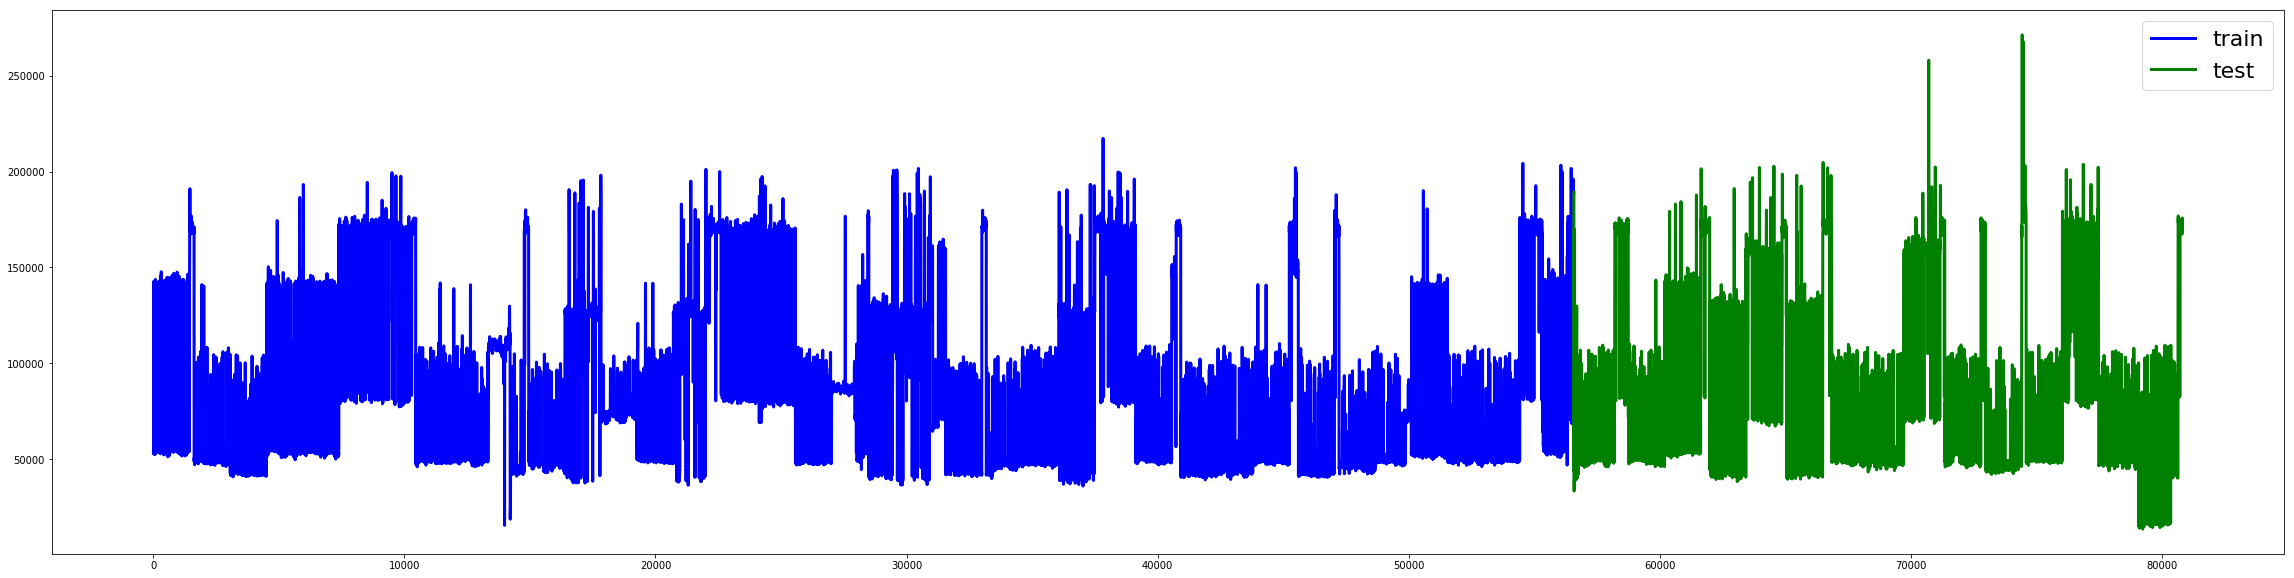

==================== Forecast


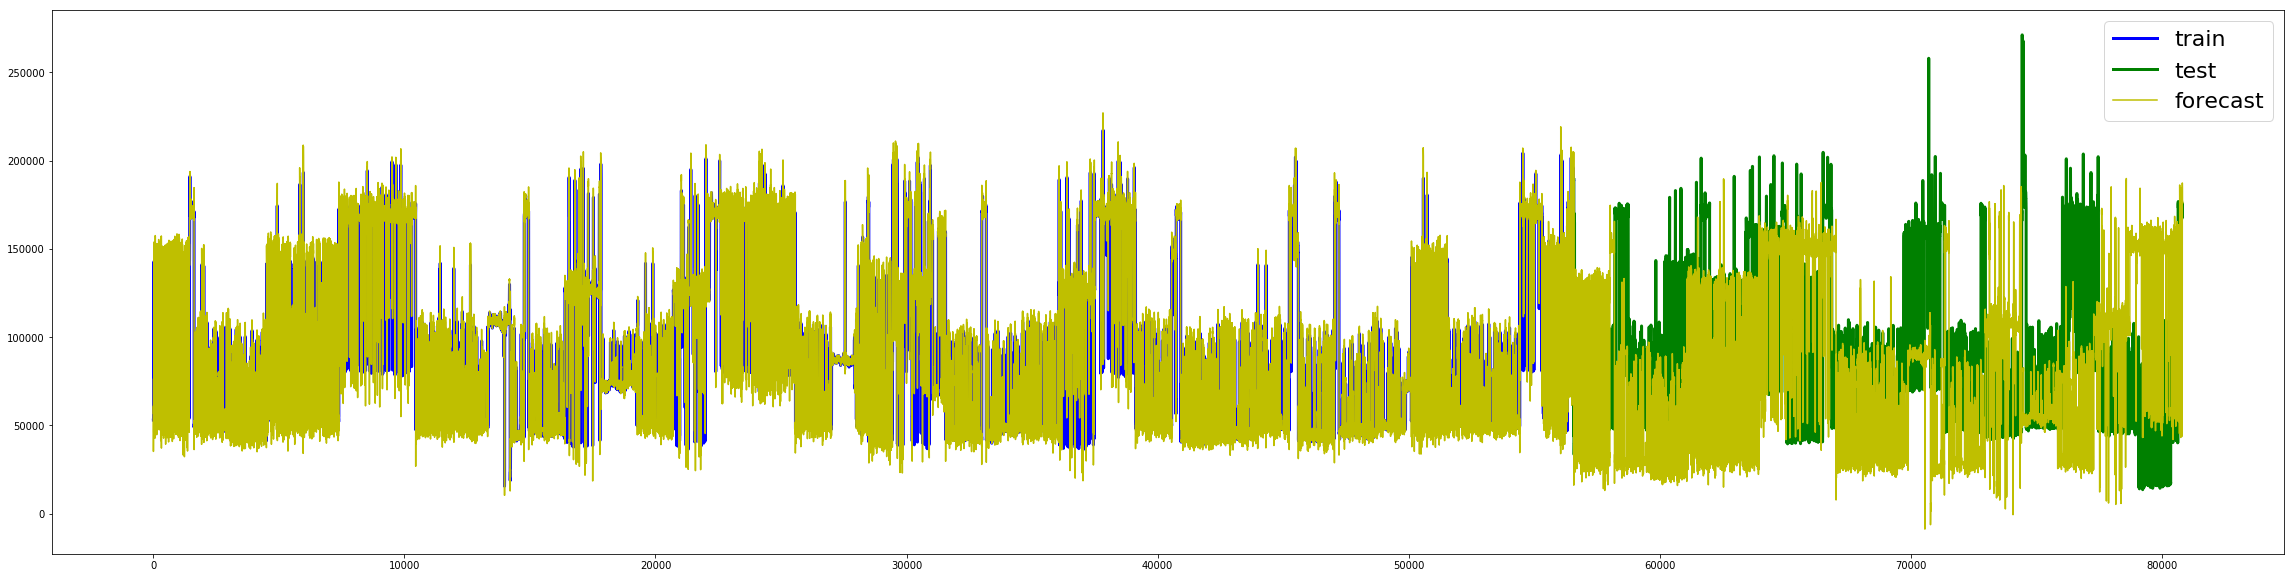

In [9]:
ind = 728
key = key_vals[ind]
df = dfs[key]
train, test, forecast = generate_forecast_and_graphs(df, key)
filename = "forecasts/forecast_" + metric_name + "_" + str(ind) + ".pkl"
save_forecast(filename, train, test, forecast)

Metadata:  {'__name__': 'http_request_duration_microseconds', 'beta_kubernetes_io_arch': 'amd64', 'beta_kubernetes_io_fluentd_ds_ready': 'true', 'beta_kubernetes_io_instance_type': 'm4.xlarge', 'beta_kubernetes_io_os': 'linux', 'clam_controller_enabled': 'True', 'clam_server_enabled': 'True', 'failure_domain_beta_kubernetes_io_region': 'us-east-2', 'failure_domain_beta_kubernetes_io_zone': 'us-east-2a', 'fluentd_test': 'true', 'handler': 'prometheus', 'hostname': 'free-stg-master-03fb6', 'instance': 'ip-172-31-78-254.us-east-2.compute.internal', 'job': 'kubernetes-nodes', 'kubernetes_io_hostname': 'ip-172-31-78-254.us-east-2.compute.internal', 'node_role_kubernetes_io_master': 'true', 'quantile': '0.5', 'region': 'us-east-2', 'type': 'master'}
==================== Raw Data


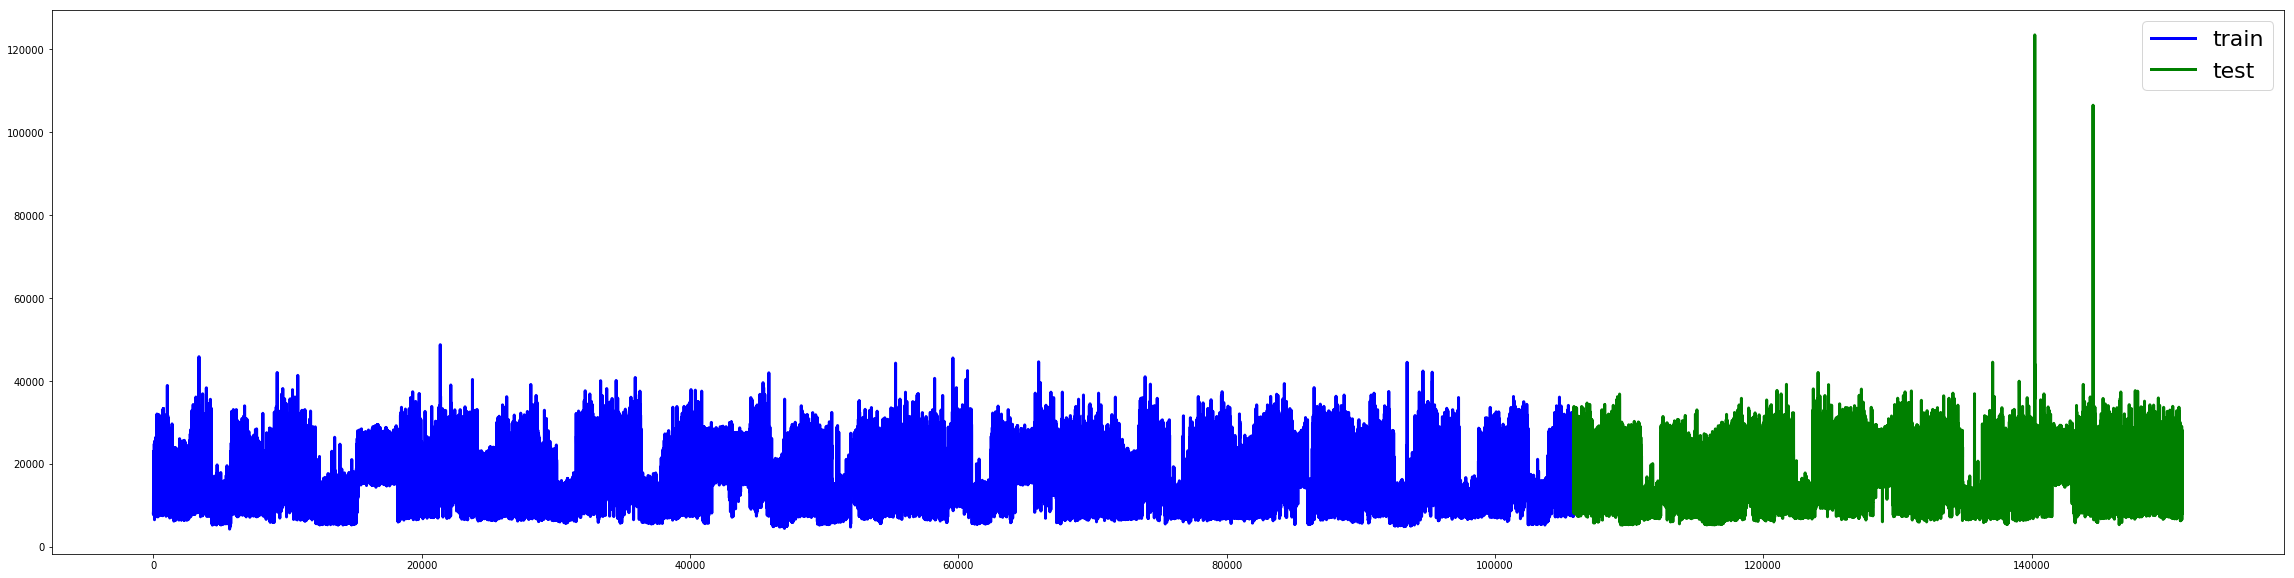

==================== Forecast


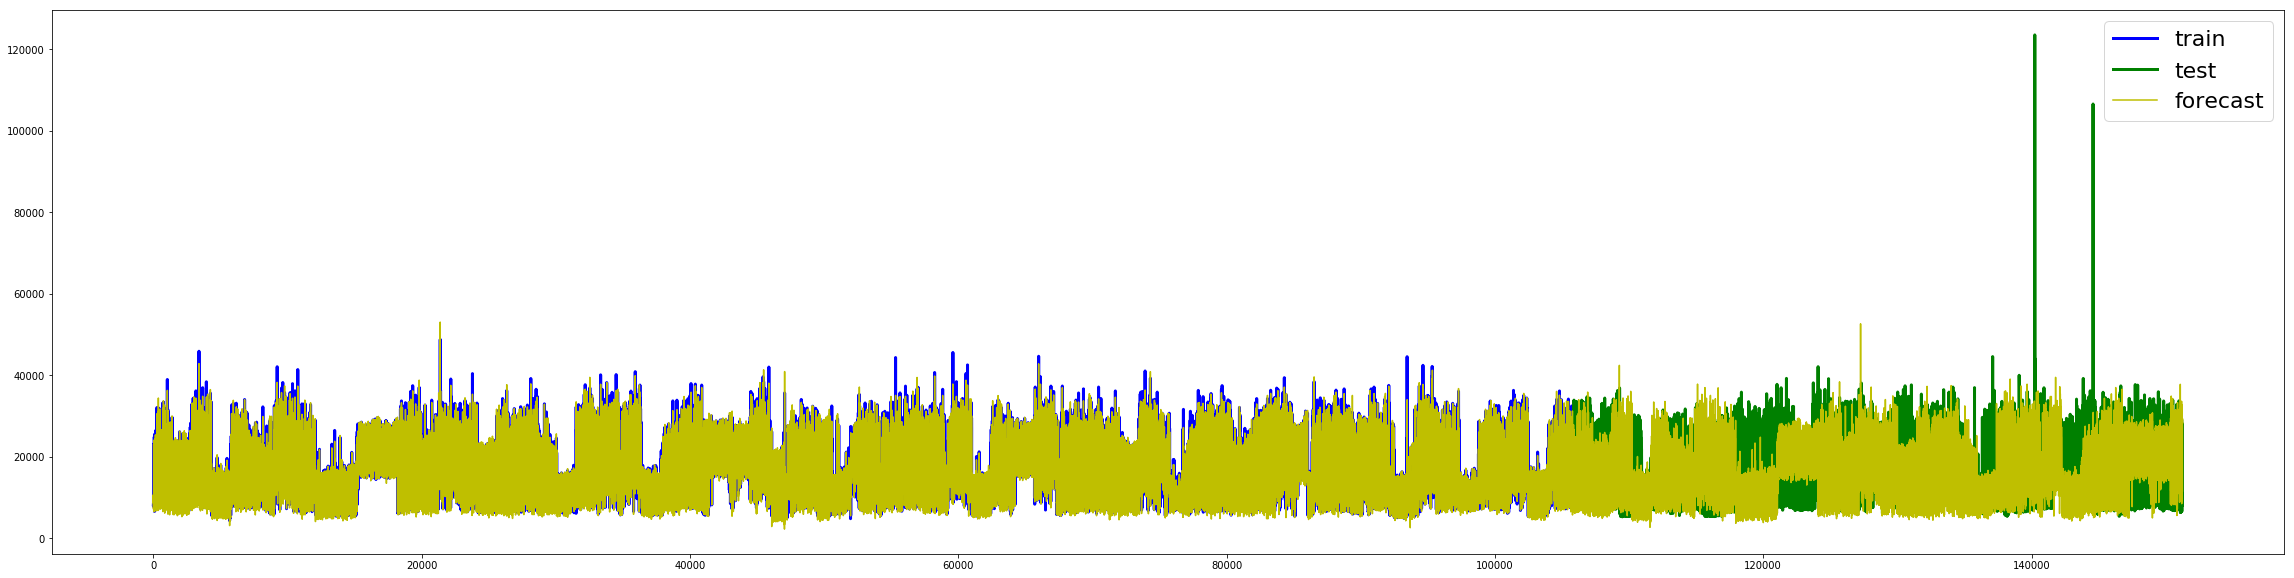

In [10]:
ind = 9
key = key_vals[ind]
df = dfs[key]
train, test, forecast = generate_forecast_and_graphs(df, key)
filename = "forecasts/forecast_" + metric_name + "_" + str(ind) + ".pkl"
save_forecast(filename, train, test, forecast)

Metadata:  {'__name__': 'http_request_duration_microseconds', 'handler': 'prometheus', 'instance': '10.129.3.53:8443', 'job': 'kubernetes-service-endpoints', 'kubernetes_name': 'prom', 'kubernetes_namespace': 'openshift-devops-monitor', 'name': 'prom', 'quantile': '0.9'}
==================== Raw Data


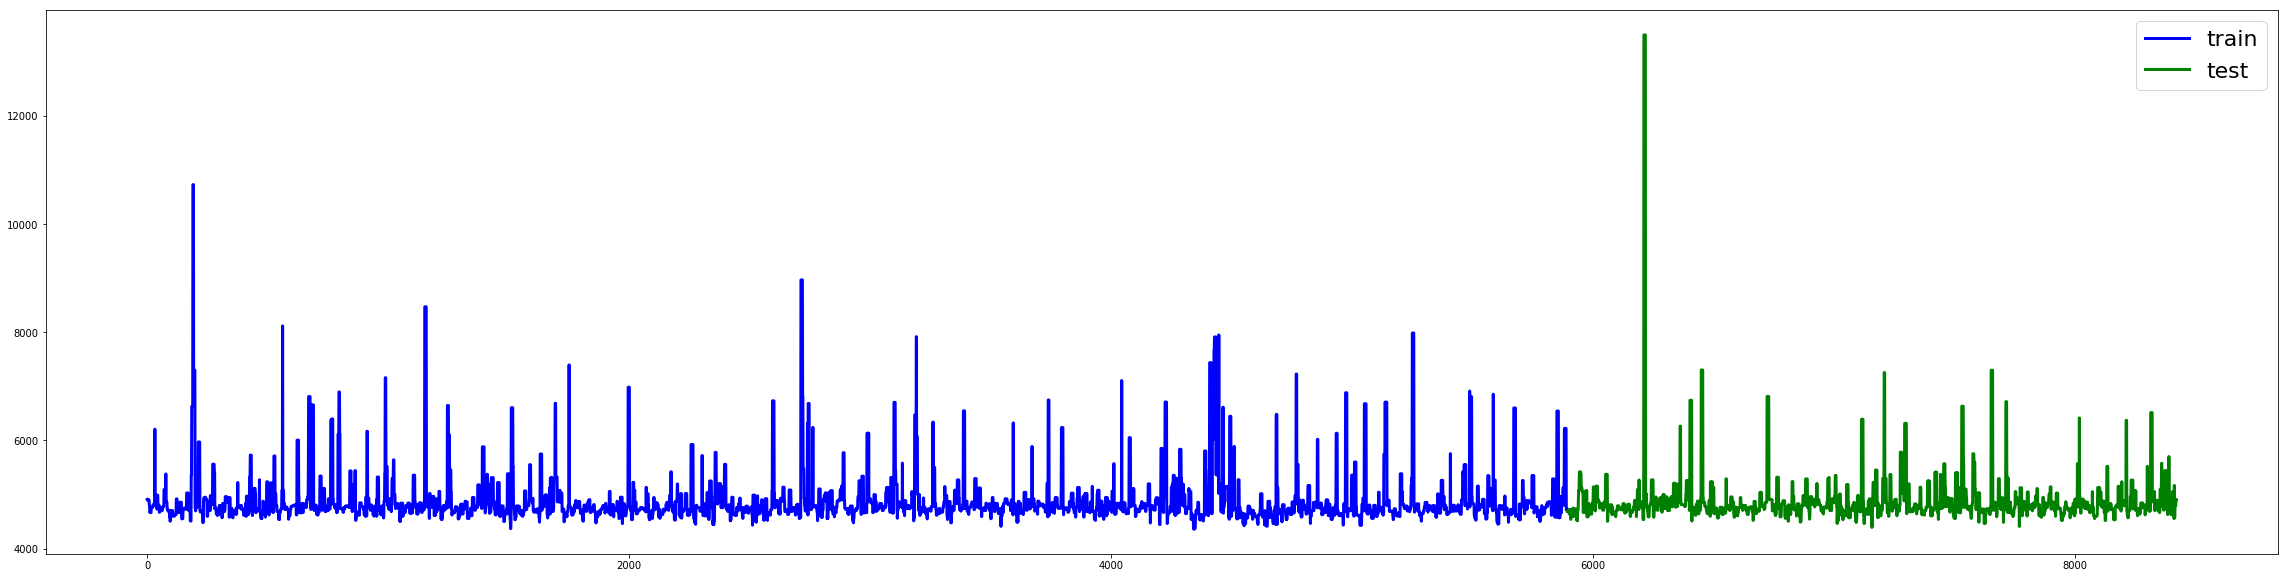

==================== Forecast


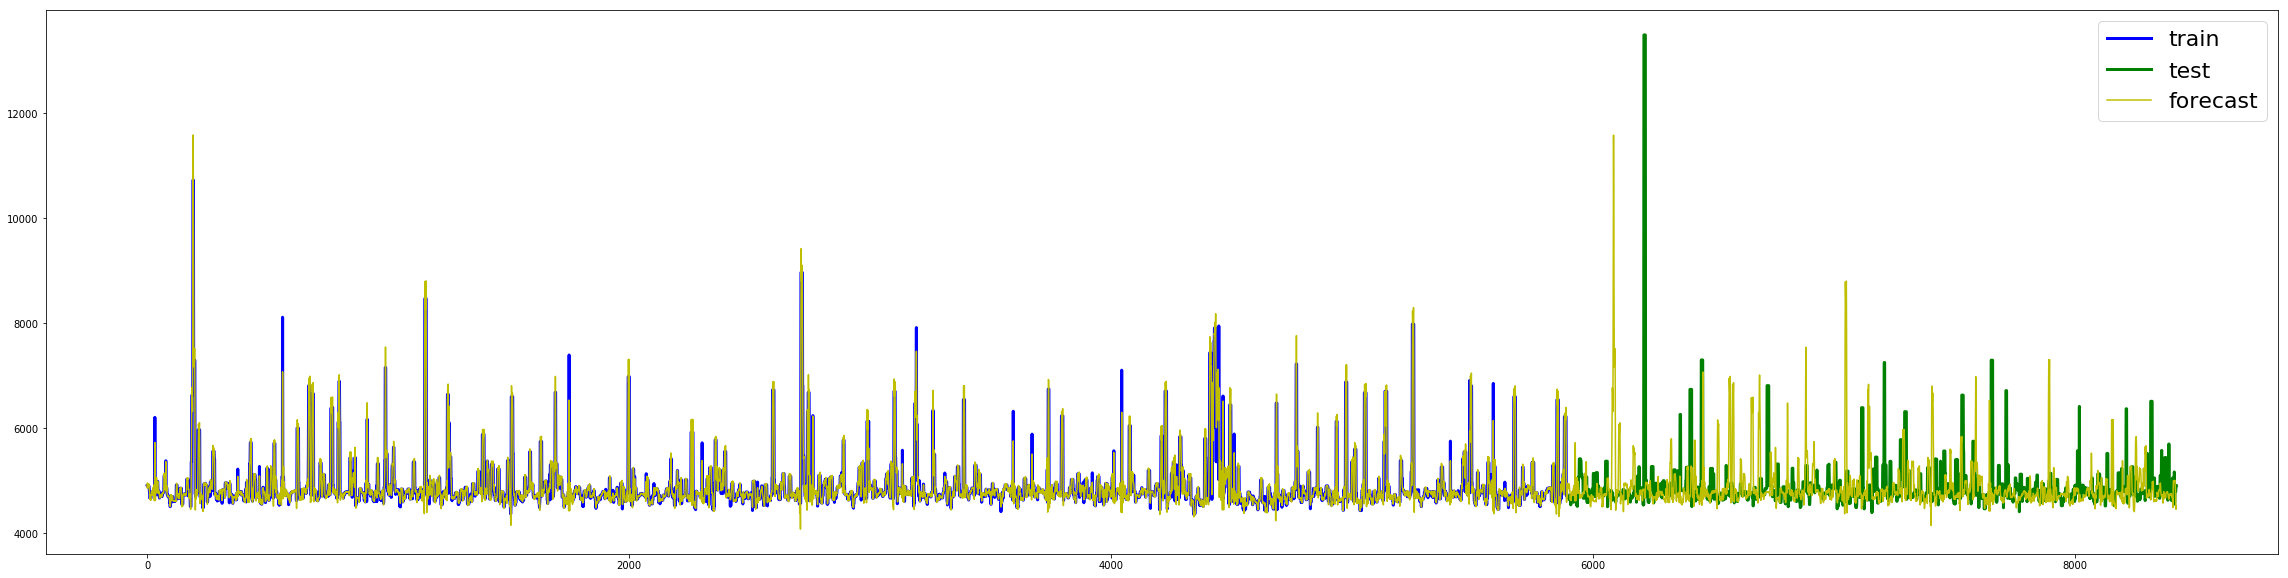

In [11]:
ind = 853
key = key_vals[ind]
df = dfs[key]
train, test, forecast = generate_forecast_and_graphs(df, key)
filename = "forecasts/forecast_" + metric_name + "_" + str(ind) + ".pkl"
save_forecast(filename, train, test, forecast)

Metadata:  {'__name__': 'http_request_duration_microseconds', 'beta_kubernetes_io_arch': 'amd64', 'beta_kubernetes_io_instance_type': 'r4.xlarge', 'beta_kubernetes_io_os': 'linux', 'failure_domain_beta_kubernetes_io_region': 'us-east-2', 'failure_domain_beta_kubernetes_io_zone': 'us-east-2a', 'handler': 'prometheus', 'hostname': 'free-stg-node-infra-a18ed', 'instance': 'ip-172-31-73-38.us-east-2.compute.internal', 'job': 'kubernetes-nodes', 'kubernetes_io_hostname': 'ip-172-31-73-38.us-east-2.compute.internal', 'logging_infra_fluentd': 'true', 'node_role_kubernetes_io_compute': 'true', 'node_role_kubernetes_io_infra': 'true', 'quantile': '0.9', 'region': 'us-east-2', 'type': 'infra'}
==================== Raw Data


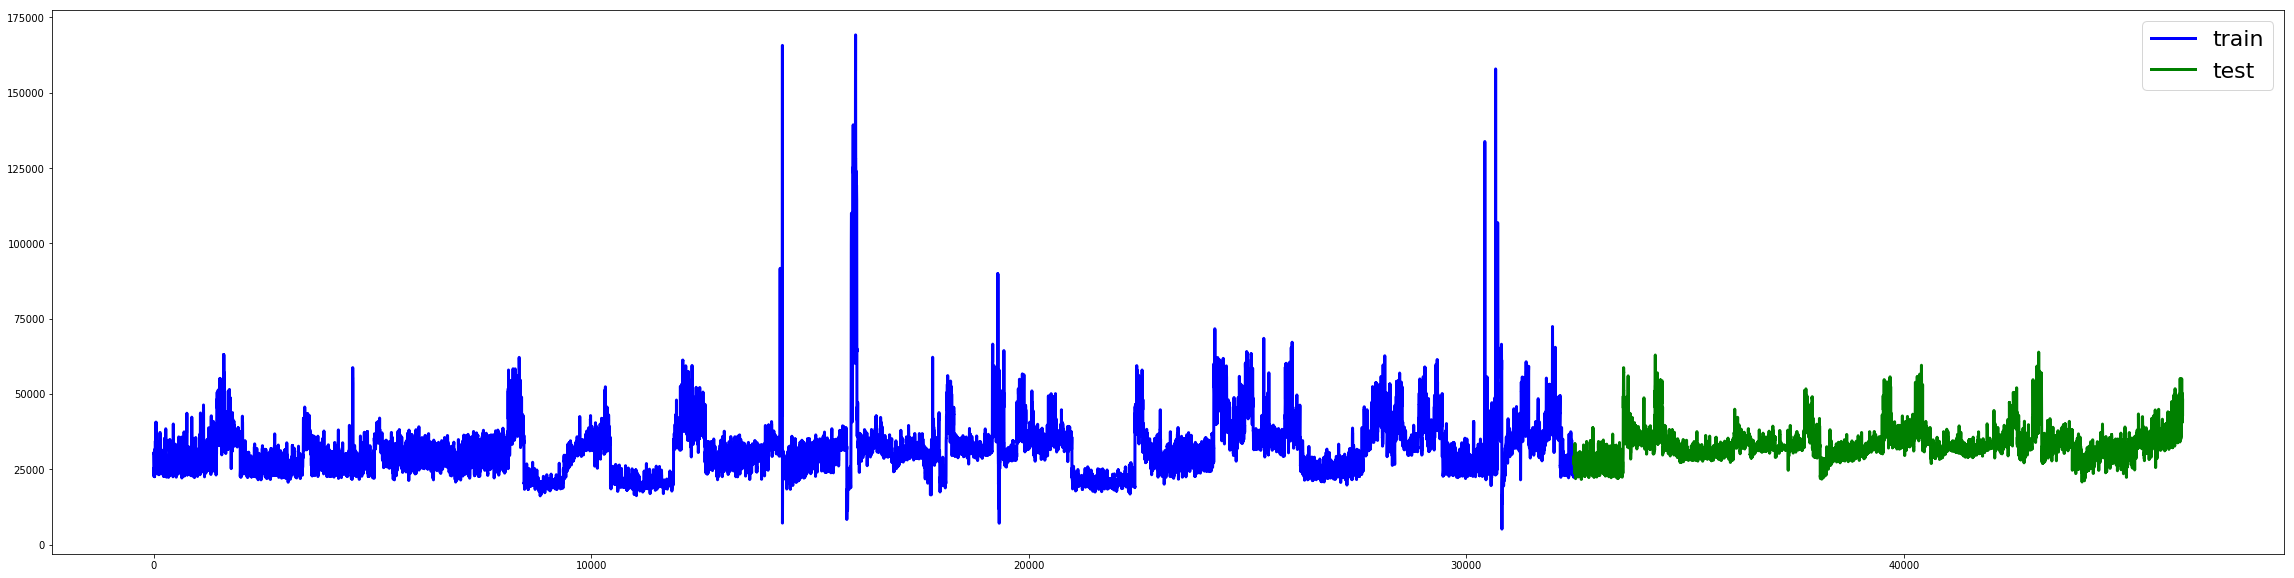

==================== Forecast


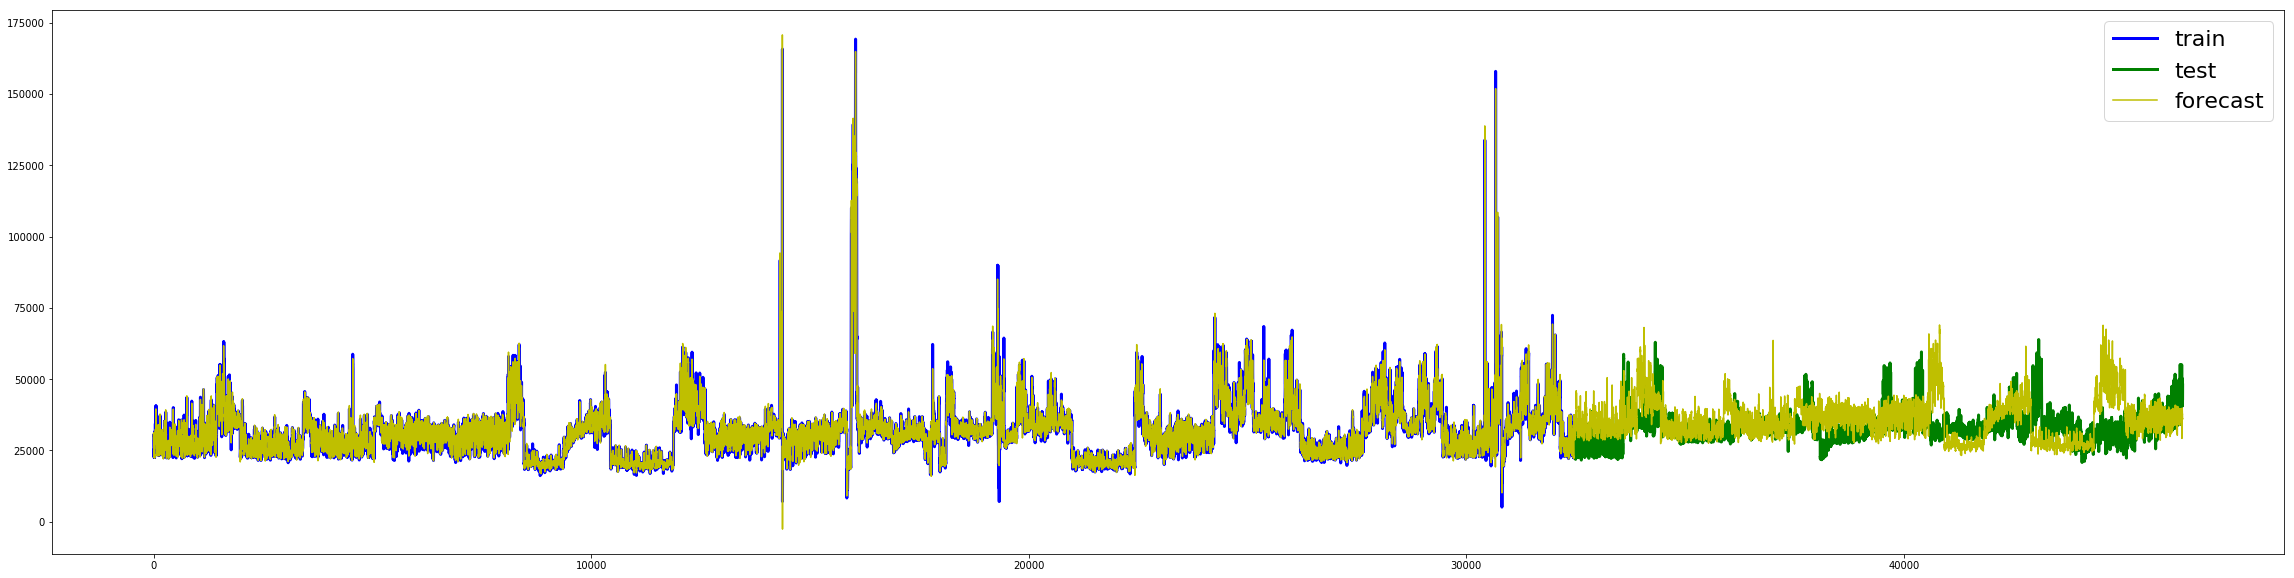

In [12]:
ind = 760
key = key_vals[ind]
df = dfs[key]
train, test, forecast = generate_forecast_and_graphs(df, key)
filename = "forecasts/forecast_" + metric_name + "_" + str(ind) + ".pkl"
save_forecast(filename, train, test, forecast)

Metadata:  {'__name__': 'http_request_duration_microseconds', 'beta_kubernetes_io_arch': 'amd64', 'beta_kubernetes_io_instance_type': 'm4.xlarge', 'beta_kubernetes_io_os': 'linux', 'failure_domain_beta_kubernetes_io_region': 'us-east-2', 'failure_domain_beta_kubernetes_io_zone': 'us-east-2a', 'handler': 'prometheus', 'instance': 'ip-172-31-79-95.us-east-2.compute.internal', 'job': 'kubernetes-nodes', 'kubernetes_io_hostname': 'ip-172-31-79-95.us-east-2.compute.internal', 'node_role_kubernetes_io_compute': 'true', 'quantile': '0.99', 'region': 'us-east-2', 'runtime': 'cri-o', 'type': 'compute'}
==================== Raw Data


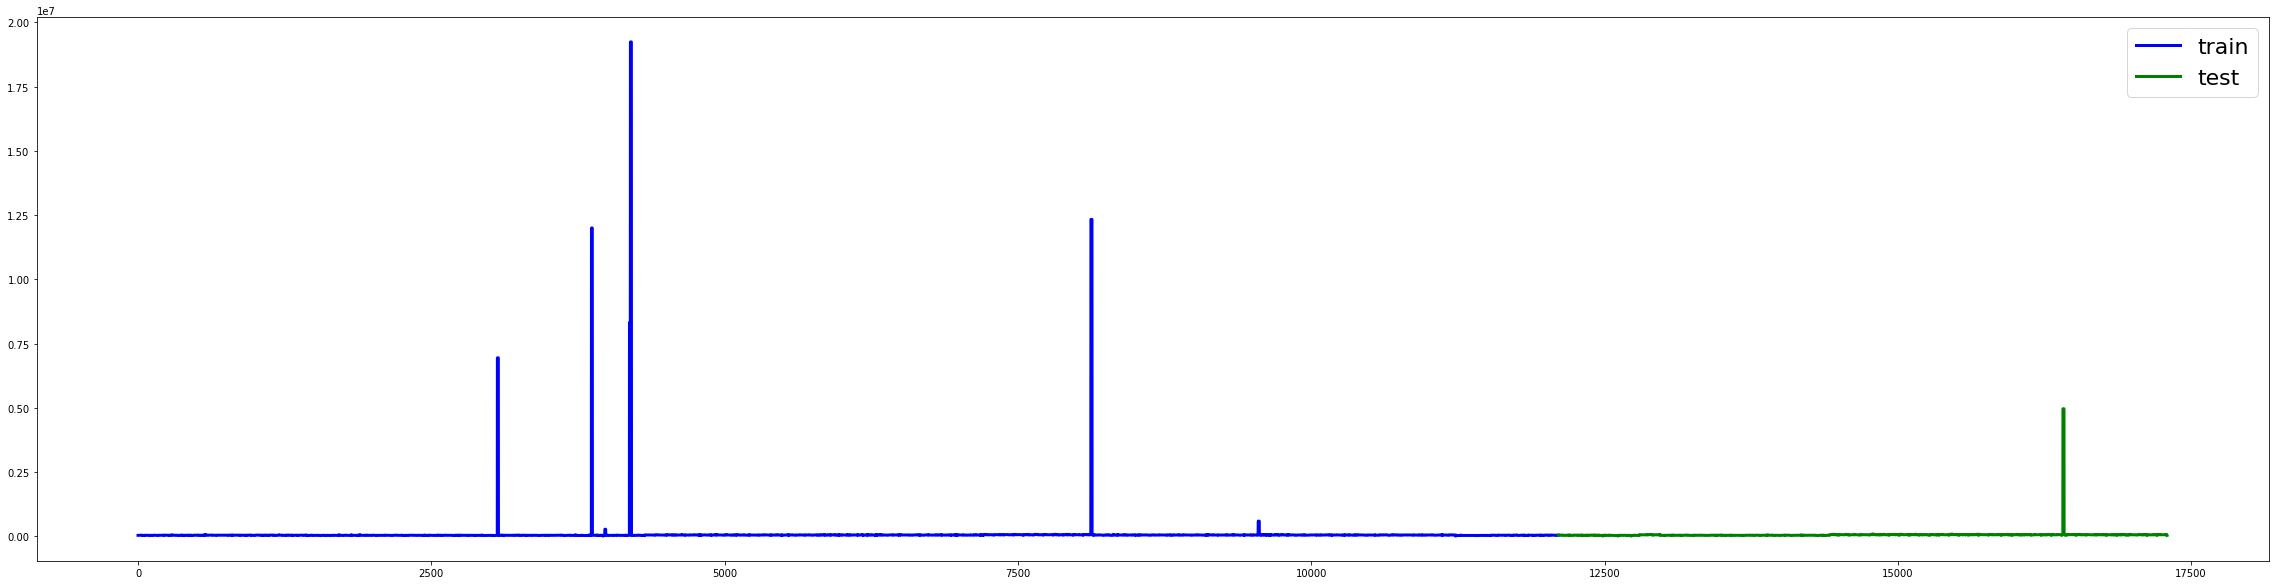

==================== Forecast


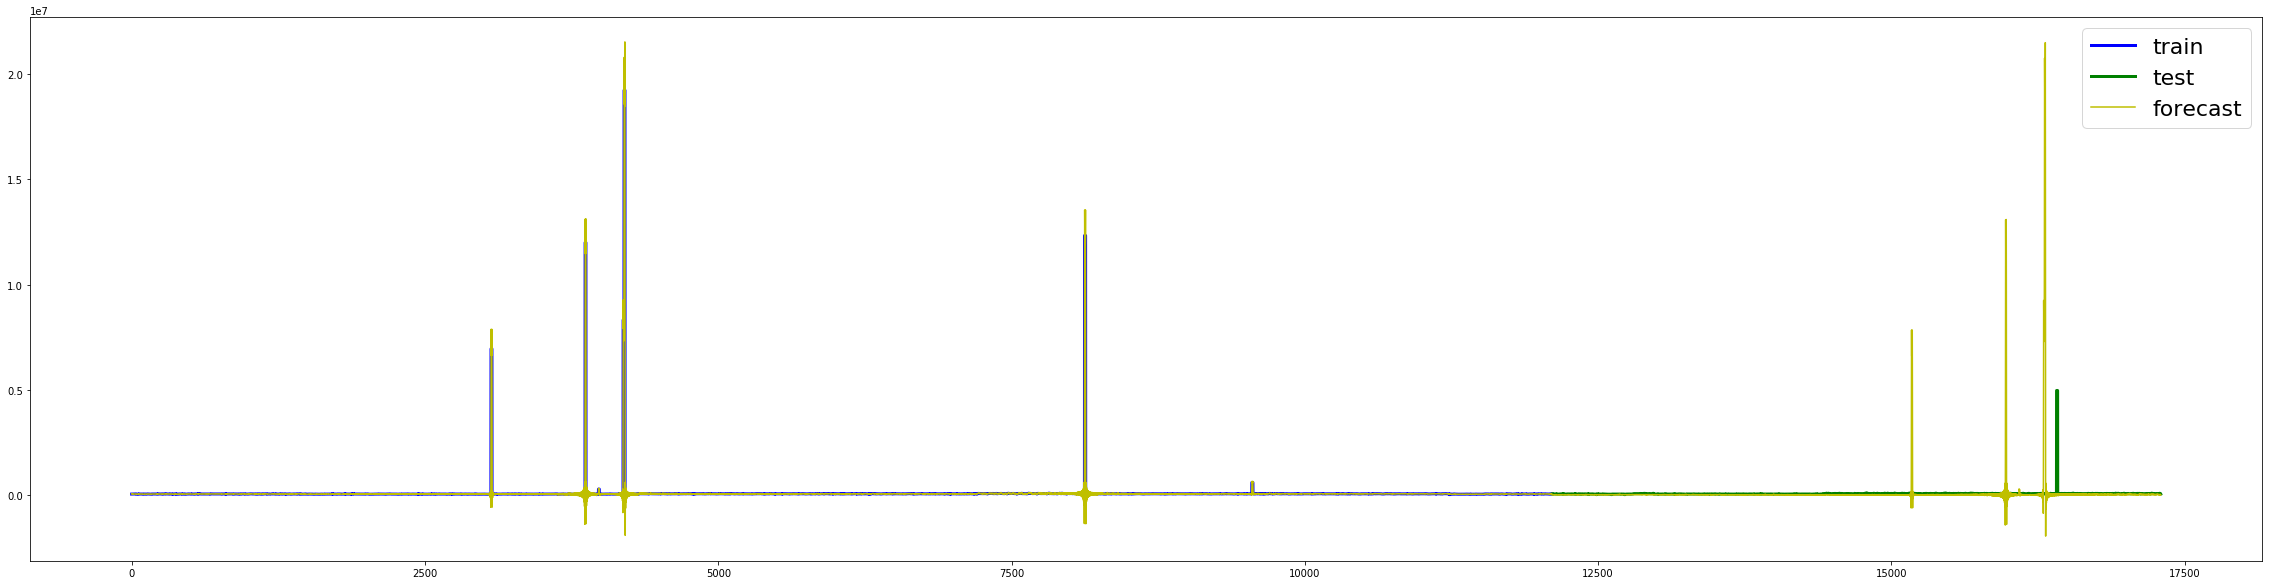

In [13]:
ind = 752
key = key_vals[ind]
df = dfs[key]
train, test, forecast = generate_forecast_and_graphs(df, key)
filename = "forecasts/forecast_" + metric_name + "_" + str(ind) + ".pkl"
save_forecast(filename, train, test, forecast)

Metadata:  {'__name__': 'http_request_duration_microseconds', 'beta_kubernetes_io_arch': 'amd64', 'beta_kubernetes_io_instance_type': 'm4.xlarge', 'beta_kubernetes_io_os': 'linux', 'failure_domain_beta_kubernetes_io_region': 'us-east-2', 'failure_domain_beta_kubernetes_io_zone': 'us-east-2a', 'handler': 'prometheus', 'hostname': 'free-stg-node-compute-e0756', 'instance': 'ip-172-31-76-144.us-east-2.compute.internal', 'job': 'kubernetes-nodes', 'kubernetes_io_hostname': 'ip-172-31-76-144.us-east-2.compute.internal', 'logging_infra_fluentd': 'true', 'node_role_kubernetes_io_compute': 'true', 'quantile': '0.9', 'region': 'us-east-2', 'type': 'compute'}
==================== Raw Data


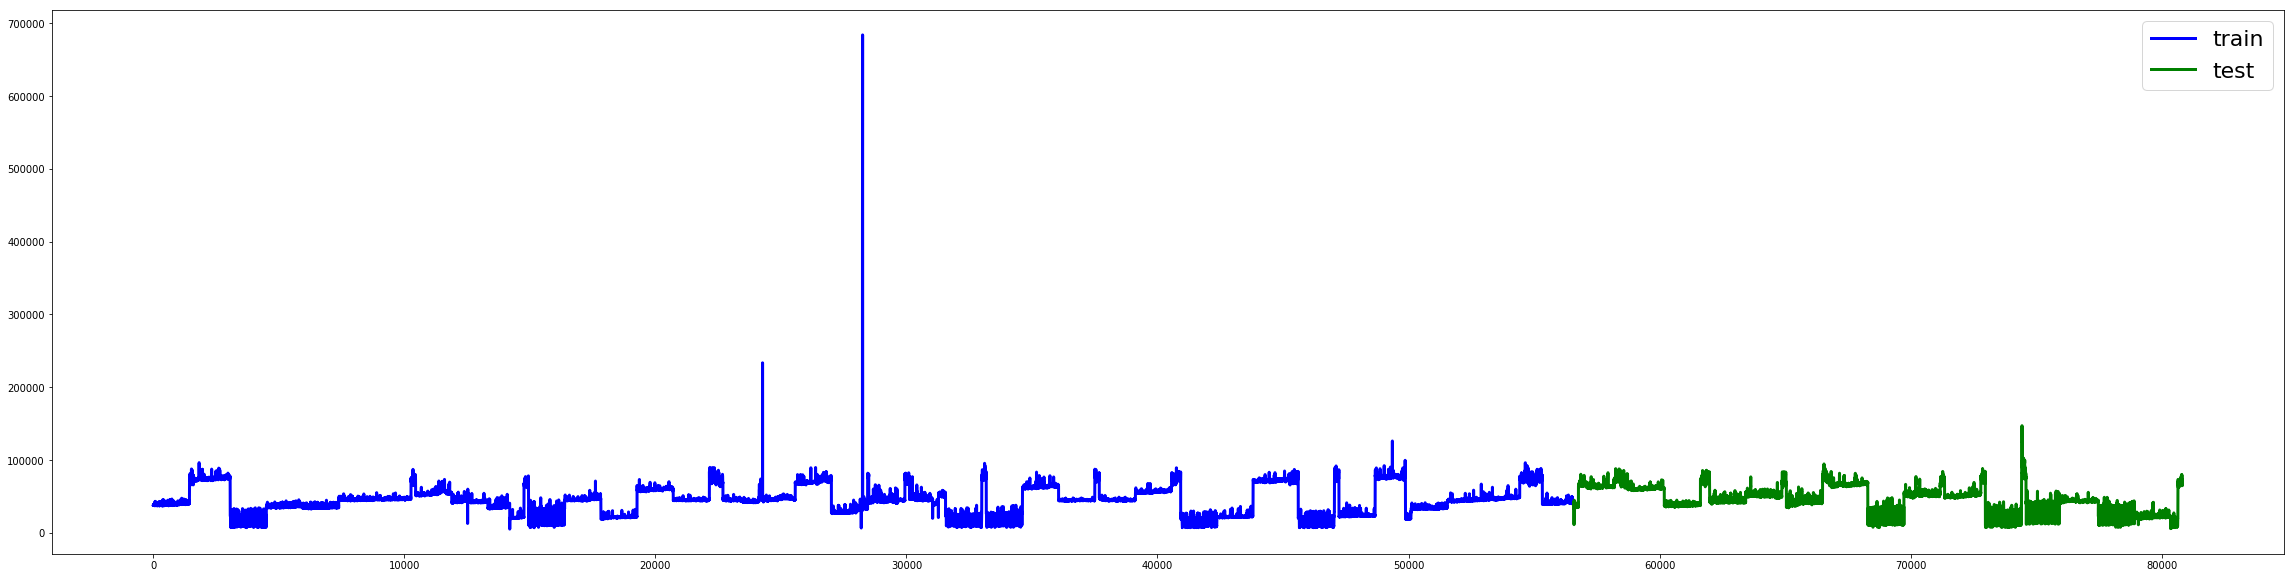

==================== Forecast


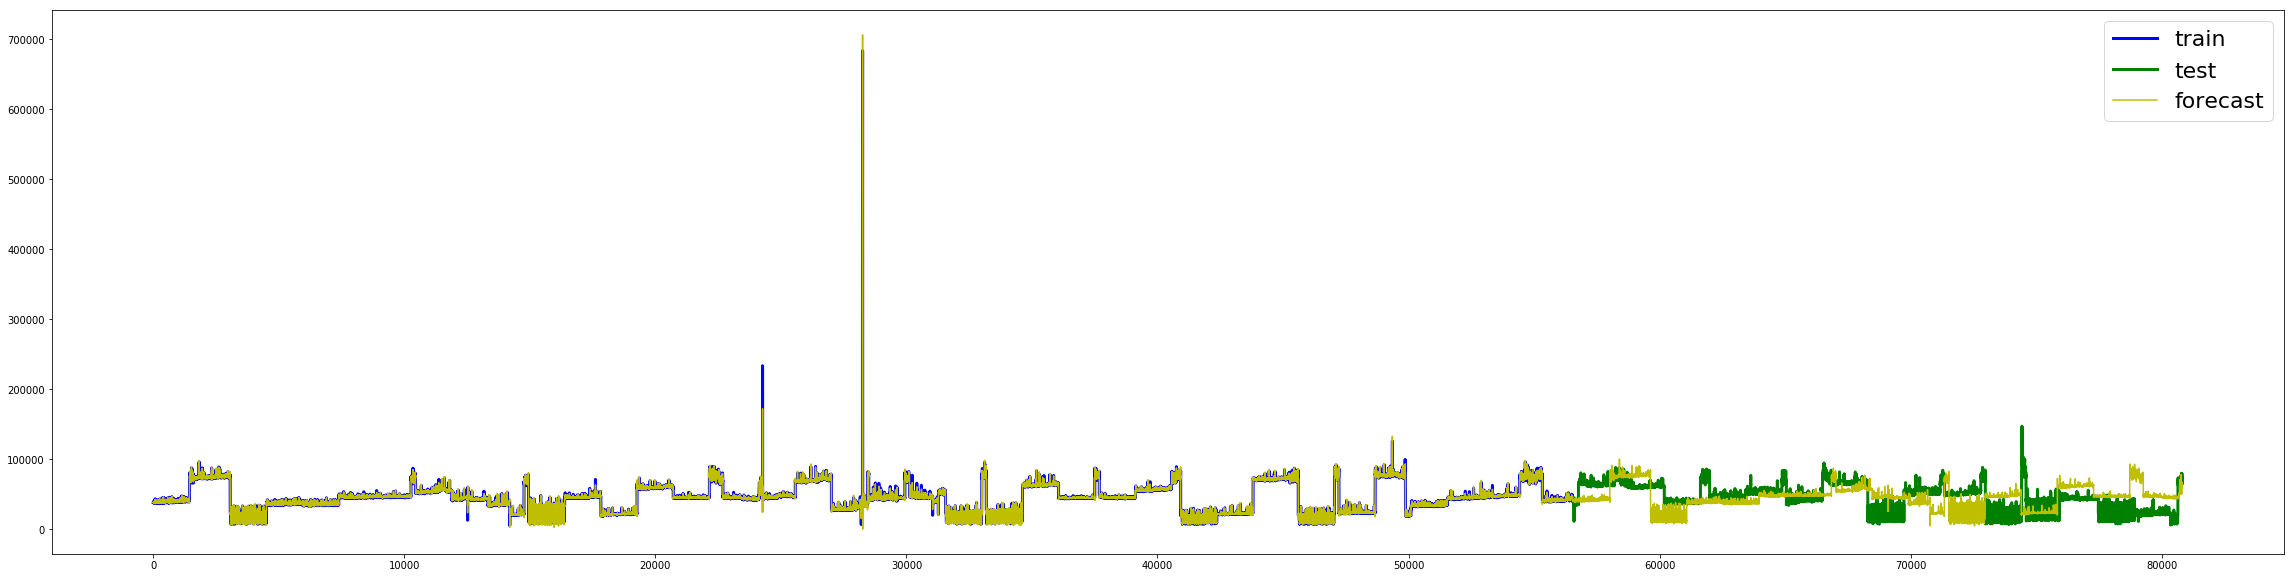

In [14]:
ind = 724
key = key_vals[ind]
df = dfs[key]
train, test, forecast = generate_forecast_and_graphs(df, key)
filename = "forecasts/forecast_" + metric_name + "_" + str(ind) + ".pkl"
save_forecast(filename, train, test, forecast)

Metadata:  {'__name__': 'http_request_duration_microseconds', 'beta_kubernetes_io_arch': 'amd64', 'beta_kubernetes_io_instance_type': 'm4.xlarge', 'beta_kubernetes_io_os': 'linux', 'failure_domain_beta_kubernetes_io_region': 'us-east-2', 'failure_domain_beta_kubernetes_io_zone': 'us-east-2a', 'handler': 'prometheus', 'hostname': 'free-stg-node-compute-4b2e9', 'instance': 'ip-172-31-68-79.us-east-2.compute.internal', 'job': 'kubernetes-nodes-exporter', 'kubernetes_io_hostname': 'ip-172-31-68-79.us-east-2.compute.internal', 'logging_infra_fluentd': 'true', 'node_role_kubernetes_io_compute': 'true', 'quantile': '0.99', 'region': 'us-east-2', 'type': 'compute'}
==================== Raw Data


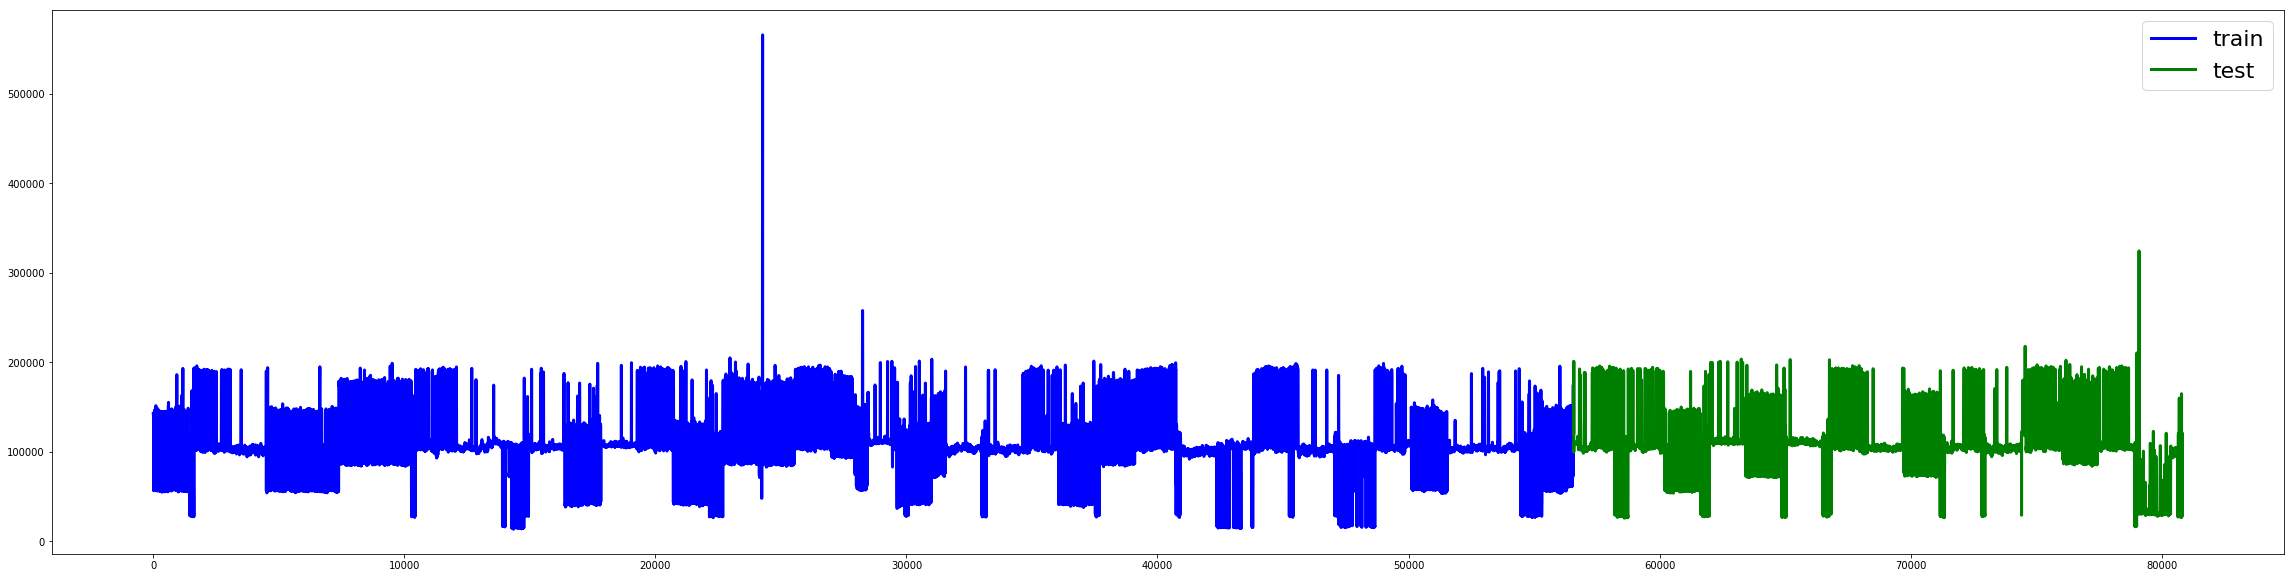

==================== Forecast


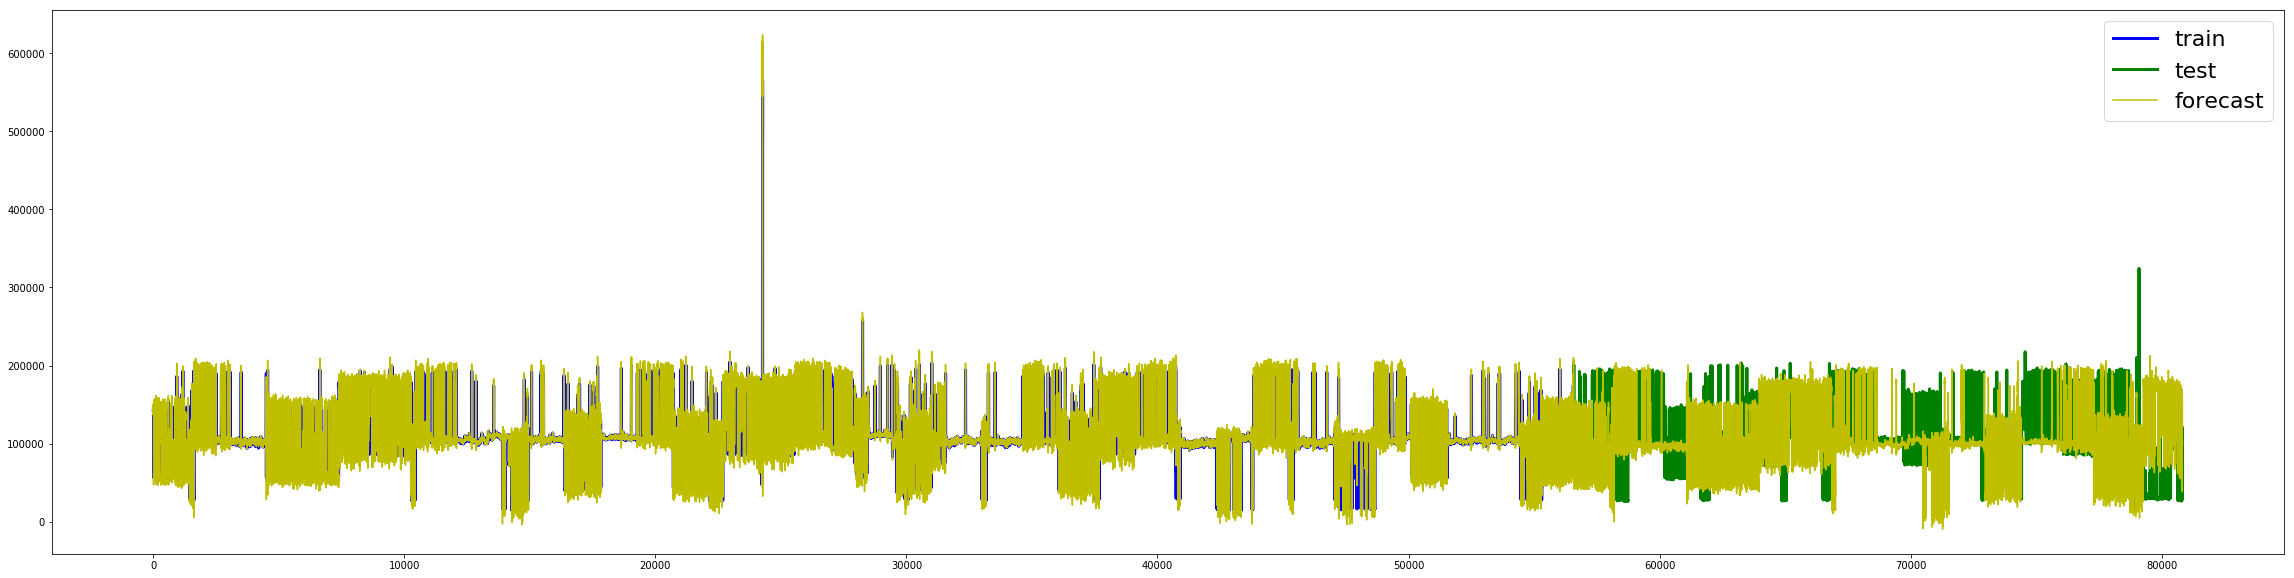

In [15]:
ind = 698
key = key_vals[ind]
df = dfs[key]
train, test, forecast = generate_forecast_and_graphs(df, key)
filename = "forecasts/forecast_" + metric_name + "_" + str(ind) + ".pkl"
save_forecast(filename, train, test, forecast)